<h1><center><b> Acquired Intelligence & Adaptive Behaviour </b></center></h1>
<h2><center><i>Course Work 2 (coding part)</i></center></h2>

<center>Candidate no: 246743</center>




# TASK

Write a report that examines the evolution of behavior on the cart pole task (or any other task). Successfully optimise the controller to achieve greater than 95% accuracy on the cart pole task model provided in the worksheet. You can use a GA, or a population of hillclimbers, or any other algorithm you wish to construct (but don't use an optimization package). 

<br>

-**Minimal required  technical achievements**

<br>

* Demonstrate that the controller is evolving with a plot of best fitness versus tournaments for several runs of your algorithm. 
* Demonstrate with plots the behavior of the successful controller, e.g., plot angle versus time, angular velocity versus time, or provide a link to a video.
* Show examples of the best controller after 0 tournaments, halfway through the run,  and at the end of optimization, and describe what changes in the behavior. 
* You might consider choosing behaviors associated with jumps in fitness (GA’s often exhibit plateaus and then sudden jumps).

# Import

In [ ]:
import copy
import gym
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

# Individual

In [ ]:
class Individual(object):

  def __init__(self):
    self._genotype = []
    self._fitness = 0

  def get_gene(self, i):
    return self._genotype[i]

  def set_gene(self, gene, i):
    self._genotype[i] = gene

  def get_genotype(self):
    return self._genotype

  def set_genotype(self, genotype):
    self._genotype = genotype

  def get_fitness(self):
    return self._fitness

  def set_fitness(self, fitness):
    self._fitness = fitness

# Population

In [ ]:
class Population(object):

  def __init__(self, size):
    self._size = size
    self._population = []

  def initialise_population(self, num_gene_each_idv):
    gene_pop = np.random.normal(0, 0.1, (self._size, num_gene_each_idv))
    for i in range(self._size):
      self._population.append(Individual())
      self._population[i].set_genotype(gene_pop[i])

  def get_best_individual(self):
    target = np.argmax(self.get_pop_fitness())
    return self._population[target]

  def get_population(self):
    return self._population

  def get_pop_fitness(self):
    result = []
    for idx in range(self._size):
      result.append(self._population[idx].get_fitness())
      # print('idx: ', idx, '\nfitness: ', self._population[idx].get_fitness())
    return result

  def get_max_fitness(self):
    best = self.get_best_individual()
    return best.get_fitness()

  def get_avg_fitness(self):
    result = self.get_pop_fitness()
    return np.average(result)

  def modify_population(self, elite, loser, i):
    self._population[:i] = elite
    self._population[i:] = loser

# Agent

In [ ]:
class Agent(object):

  def __init__(self, num_input, num_output):
    self.num_input = num_input
    self.num_output = num_output
    self.num_genes = num_input * num_output + num_output
    self.weights = None
    self.bias = None

  def set_genes(self, gene):
    weight_idx = self.num_input * self.num_output
    bias_idx = self.num_input * self.num_output + self.num_output
    w = gene[0: weight_idx].reshape(self.num_output, self.num_input)
    b = gene[weight_idx: bias_idx].reshape(self.num_output)
    self.weights = torch.from_numpy(w)
    self.bias = torch.from_numpy(b)

  def get_action(self, obs):
    obs = torch.from_numpy(obs).unsqueeze(0)
    # use this line if run it in Google Colab
    forward = torch.mm(obs, self.weights.T) + self.bias
    # use this line if run it in Pycharm
    # forward = torch.mm(obs, self.weights.T.to(torch.float32)) + self.bias
    if forward > 0:
      return 1
    else:
      return 0

# Environment

In [ ]:
class Environment(object):

  def __init__(self, pop_size, score, agent):
    # Parameters
    self._pop_size = pop_size
    self._score = score  # target score 500
    self.agent = agent

    # Infrastructure
    self._env = gym.make('CartPole-v1')
    self._pop = Population(self._pop_size)
    self._pop.initialise_population(self.agent.num_genes)

    # Record helpers
    self.best_controller = []
    self.best_record = []
    self._epoch = 0
    self._start = time.time()
    self._end = 0

  def _run_episode(self):
    total_reward = 0.0
    obs = self._env.reset()
    for i in range(self._score):
      action = self.agent.get_action(obs)
      obs, reward, done, info = self._env.step(action)
      total_reward += reward
      if done: break
    return total_reward

  def _calc_fitness(self, pop):
    for i, indv in enumerate(pop.get_population()):
      self.agent.set_genes(indv.get_genotype())
      pop.get_population()[i].set_fitness(self._run_episode())
    return pop.get_pop_fitness()

  def _elitism(self, elite_num):
    fitness_sort = np.zeros(self._pop_size, dtype=np.int_)
    fitness_sort[::-1] = np.asarray(self._pop.get_pop_fitness(), dtype=np.int_).argsort()
    elite = []
    for i in range(len(fitness_sort)):
      elite.append(self._pop.get_population()[i])
    return elite[:elite_num], elite[elite_num:]

  def _mutation(self, loser_group, prob=0.2):

    for loser_idv in loser_group:
      original_idv = copy.deepcopy(loser_idv)
      new_idv = copy.deepcopy(loser_idv)
      roll = np.random.uniform()

      if roll < prob:
        for i in range(len(loser_idv.get_genotype())):
          new_idv.set_gene(np.random.normal(0, 0.1, 1)[0], i)
          # new_idv.set_gene(np.random.rand(), i)

          self.agent.set_genes(original_idv.get_genotype())
          org_fitness = self._run_episode()
          self.agent.set_genes(new_idv.get_genotype())
          new_fitness = self._run_episode()

          if new_fitness > org_fitness:
            loser_idv.set_genotype(new_idv.get_genotype())

    return loser_group

  def _crossover(self, elite_group, loser_group, prob=0.8):

    crossed_pop = []
    for a in range(len(loser_group)):
      good_one = np.random.choice(elite_group)
      bad_one = np.random.choice(loser_group)

      for i in range(len(bad_one.get_genotype())):
        roll = np.random.uniform()
        if roll < prob:
          bad_one.set_gene(good_one.get_genotype()[i], i)
        crossed_pop.append(bad_one)

    return crossed_pop

  def run(self, num_epoch, elite_num, cross_rate, mutate_rate):
    while self._epoch < num_epoch:
      self._epoch += 1

      elite, loser = self._elitism(elite_num)
      altered_loser = self._crossover(elite, loser, prob=cross_rate)
      altered_loser = self._mutation(altered_loser, prob=mutate_rate)
      self._pop.modify_population(elite, altered_loser, elite_num)

      pop_fitness = self._calc_fitness(self._pop)
      best_idv = self._pop.get_best_individual()
      self.best_controller.append(best_idv)
      best_fitness = best_idv.get_fitness()
      self.best_record.append(best_fitness)
      if self._epoch % 200 == 0:
        print('Generation %d  --  Max Fitness = %.3f -- Mean Fitness = %.3f'
            % (self._epoch, best_idv.get_fitness(), self._pop.get_avg_fitness()))
      if best_fitness >= self._score: break

    self._end = time.time()
    print('---------COMPLETED---------')
    print('Best Fitness = %.3f, in Generation %d, Current Mean = %.3f'
        % (self._pop.get_max_fitness(), self._epoch, self._pop.get_avg_fitness()))
    print('Best Genotype is: ', self._pop.get_best_individual().get_genotype())
    print('Time Spent = %.3f sec' % (self._end - self._start))
    return self._pop.get_best_individual()

# —————————————

# Start running

In [ ]:
pop_size = 50
num_obs, num_actions = 4, 1

# Training
agent = Agent(num_obs, num_actions)
model = Environment(pop_size, 500, agent)
best_individual = model.run(num_epoch=1000, elite_num=5, cross_rate=0.9, mutate_rate=0.8)

# Visualise the Best Individual
record_obs = [[], [], [], []]
agent = model.agent
agent.set_genes(best_individual.get_genotype())
obs = model._env.reset()

for i in range(500):
    # uncomment the next line if need to visualise the best individual in Pycharm
    # model._env.render()
    action = agent.get_action(obs)
    obs, reward, done, info = model._env.step(action)
    [record_obs[i].append(obs[i]) for i in range(len(obs))]
    if done: break

---------COMPLETED---------
Best Fitness = 500.000, in Generation 7, Current Mean = 307.460
Best Genotype is:  [0.05913364 0.08155533 0.1636218  0.13835828 0.03132743]
Time Spent = 20.167 sec


# Plot figures

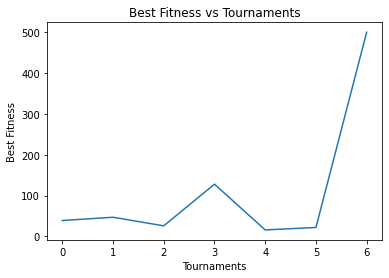

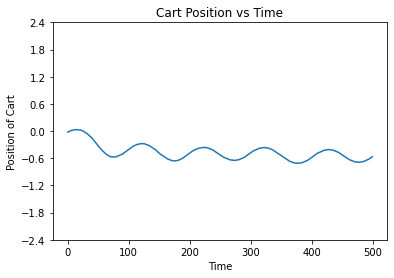

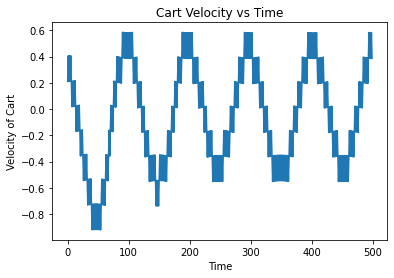

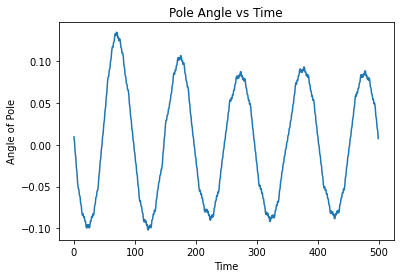

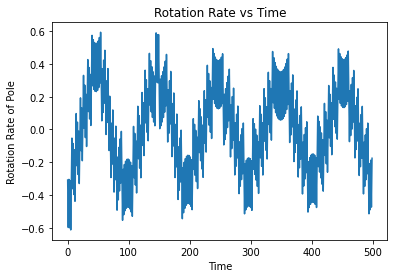

In [ ]:
plt.plot(model.best_record)
plt.title('Best Fitness vs Tournaments')
plt.xlabel('Tournaments')
plt.ylabel('Best Fitness')
plt.show()

plt.plot(record_obs[0])
plt.title('Cart Position vs Time')
plt.xlabel('Time')
plt.ylabel('Position of Cart')
plt.yticks(np.arange(-2.4, 2.5, 0.6))
plt.show()

plt.plot(record_obs[1])
plt.title('Cart Velocity vs Time')
plt.xlabel('Time')
plt.ylabel('Velocity of Cart')
plt.show()

plt.plot(record_obs[2])
plt.title('Pole Angle vs Time')
plt.xlabel('Time')
plt.ylabel('Angle of Pole')
plt.show()

plt.plot(record_obs[3])
plt.title('Rotation Rate vs Time')
plt.xlabel('Time')
plt.ylabel('Rotation Rate of Pole')
plt.show()

# Calc Accuracy

In [ ]:
pop_size = 40
num_obs, num_actions = 4, 1
fitness_record = []

# Run For 100 Times
for i in range(100):
  agent = Agent(num_obs, num_actions)
  model = Environment(pop_size, 500, agent)
  best_individual = model.run(num_epoch=3000, elite_num=8, cross_rate=0.9, mutate_rate=0.3)
  print('Training ', i, ' finished!!!')

  # set agent genes
  agent.set_genes(best_individual.get_genotype())

  # start playing & add reward
  fitness = 0.0
  obs = model._env.reset()
  for j in range(500):
    action = agent.get_action(obs)
    obs, reward, done, info = model._env.step(action)
    fitness += reward
    if done: break

  print('Fitness ', i, ' is ', fitness)
  print('-----------------------------------------------------------------')
  print('-----------------------------------------------------------------')
  fitness_record.append(fitness)


---------COMPLETED---------
Best Fitness = 500.000, in Generation 3, Current Mean = 202.250
Best Genotype is:  [-0.01109552  0.16396899  0.13204946  0.15076465  0.0069245 ]
Time Spent = 3.850 sec
Training  0  finished!!!
Fitness  0  is  500.0
-----------------------------------------------------------------
-----------------------------------------------------------------
---------COMPLETED---------
Best Fitness = 500.000, in Generation 2, Current Mean = 97.675
Best Genotype is:  [0.02727398 0.10885865 0.10852919 0.15118684 0.01601472]
Time Spent = 2.315 sec
Training  1  finished!!!
Fitness  1  is  500.0
-----------------------------------------------------------------
-----------------------------------------------------------------
---------COMPLETED---------
Best Fitness = 500.000, in Generation 3, Current Mean = 105.675
Best Genotype is:  [0.02721005 0.05069383 0.15833002 0.04121923 0.00509624]
Time Spent = 2.970 sec
Training  2  finished!!!
Fitness  2  is  500.0
------------------

In [ ]:
avg = np.mean(fitness_record)
accuracy = (avg / 500) * 100

print('Average of Best Fitness: ', avg, '\nAccuracy: ', accuracy, '%')

Average of Best Fitness:  487.57 
Accuracy:  97.514 %


In [ ]:
for i in range(10):
  a = i * 10
  b = (i+1) * 10
  print(fitness_record[a:b])

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[475.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 57.0, 500.0, 500.0, 500.0]
[500.0, 500.0, 500.0, 67.0, 478.0, 180.0, 500.0, 500.0, 500.0, 500.0]
